In [2]:
!unzip "/content/drive/MyDrive/deepfake.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [4]:
# ## 1. Data Loading and Preprocessing
# **Define data paths and parameters**
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32  # Experiment with 16 or 64
BUFFER_SIZE = tf.data.AUTOTUNE
EPOCHS = 10  # Start with a moderate number and adjust
LEARNING_RATE = 1e-4

# Function to count total images in the directory
def count_images(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        total_images += len([file for file in files if file.endswith('.jpg') or file.endswith('.png')])
    return total_images

# Get total image count for training and testing
train_dir = "/content/Dataset/Train"
test_dir = "/content/Dataset/Test"
total_train_images = count_images(train_dir)
total_test_images = count_images(test_dir)

# Calculate steps for 30% of the dataset
train_steps = int(0.3 * total_train_images // BATCH_SIZE)  # 30% of training images
test_steps = int(0.3 * total_test_images // BATCH_SIZE)    # 30% of test images

# **Data augmentation for robustness**
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# **Load 30% of data from Train folder**
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True  # Ensures random selection of images
)

# **Load 30% of data from Test folder**
validation_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True  # Ensures random selection of images
)


Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [5]:

# ## 2. Model Building (CNN + Transformer)

# **CNN Feature Extractor**
def build_cnn_extractor():
    cnn_model = tf.keras.applications.EfficientNetB4(
        include_top=False, weights="imagenet", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
    )
    # Fine-tune more layers
    for layer in cnn_model.layers[-20:]:  # Experiment with the number of layers
        layer.trainable = True
    return cnn_model

# **Positional Embedding Layer**
class PositionalEmbedding(layers.Layer):
    def __init__(self, d_model, max_seq_len=50, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(1, max_seq_len, d_model),
            initializer="random_normal",
        )

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_emb[:, :seq_len, :]

# **Transformer Encoder Block**
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# **Combine CNN and Transformer**
def build_cnn_transformer_model():
    cnn_extractor = build_cnn_extractor()
    input_layer = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # CNN Feature Extraction
    features = cnn_extractor(input_layer)
    features = layers.GlobalAveragePooling2D()(features)

    # Linearly project to d_model dimensions
    d_model = 512
    features = layers.Dense(d_model, activation='relu')(features)
    features = layers.Reshape((1, d_model))(features)

    # Transformer Layers
    num_heads = 8
    ff_dim = 2048
    dropout = 0.3  # Increase dropout for regularization

    x = PositionalEmbedding(d_model=d_model)(features)
    for _ in range(3):  # Add more transformer blocks
        x = transformer_encoder(x, d_model // num_heads, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)  # Increase dropout
    output_layer = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# **Build the model**
model = build_cnn_transformer_model()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
# ## 3. Model Compilation and Training

# **Compile the model**
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=0.001  # Increase weight decay
)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# **Learning Rate Scheduler** (A simple implementation of cyclic LR without TFA)
def lr_scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return float(lr * tf.keras.backend.get_value(tf.math.exp(-0.1)))

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# **Early Stopping and Model Checkpoint**
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True
)

In [7]:
# **Train the model**
history = model.fit(
    train_data,
    steps_per_epoch=train_steps,   # Only use 30% of training data per epoch
    epochs=EPOCHS,
    validation_data=validation_data,
    validation_steps=test_steps,  # Only use 30% of test data per epoch
    callbacks=[early_stopping, checkpoint, lr_callback],
    verbose=1,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1312/1312 ━━━━━━━━━━━━━━━━━━━━ 499s 248ms/step - accuracy: 0.7313 - loss: 0.6905 - val_accuracy: 0.8192 - val_loss: 0.6216 - learning_rate: 1.0000e-04
Epoch 2/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 302s 230ms/step - accuracy: 0.9213 - loss: 0.2300 - val_accuracy: 0.8110 - val_loss: 0.5864 - learning_rate: 1.0000e-04
Epoch 3/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 379s 289ms/step - accuracy: 0.9420 - loss: 0.1662 - val_accuracy: 0.8701 - val_loss: 0.4412 - learning_rate: 1.0000e-04
Epoch 4/10
 440/1312 ━━━━━━━━━━━━━━━━━━━━ 3:02 209ms/step - accuracy: 0.9526 - loss: 0.1326

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1312/1312 ━━━━━━━━━━━━━━━━━━━━ 104s 79ms/step - accuracy: 0.9541 - loss: 0.1296 - val_accuracy: 0.8131 - val_loss: 0.5997 - learning_rate: 9.0484e-05
Epoch 5/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 291s 221ms/step - accuracy: 0.9580 - loss: 0.1154 - val_accuracy: 0.8076 - val_loss: 0.6384 - learning_rate: 8.1873e-05
Epoch 6/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 287s 219ms/step - accuracy: 0.9640 - loss: 0.1020 - val_accuracy: 0.8180 - val_loss: 0.8131 - learning_rate: 7.4082e-05
Epoch 7/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 290s 221ms/step - accuracy: 0.9656 - loss: 0.0932 - val_accuracy: 0.8578 - val_loss: 0.4764 - learning_rate: 6.7032e-05
Epoch 8/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 101s 77ms/step - accuracy: 0.9691 - loss: 0.0807 - val_accuracy: 0.8482 - val_loss: 0.5292 - learning_rate: 6.0653e-05


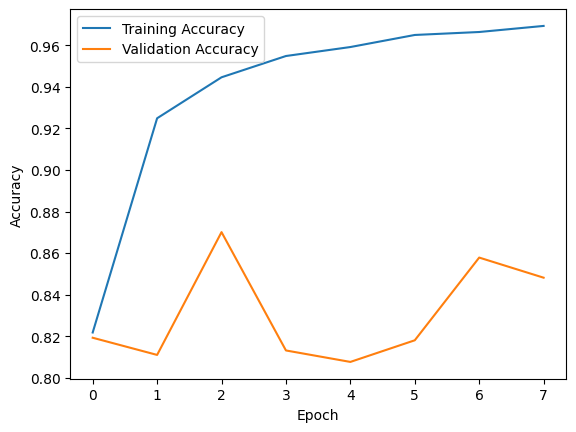

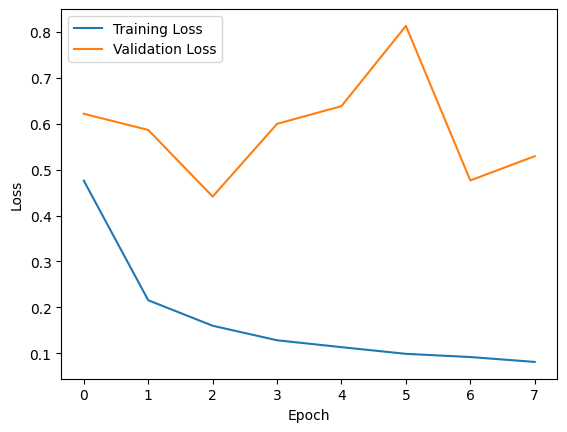

In [14]:

# ## 4. Evaluation and Visualization

# **Plot training history**
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


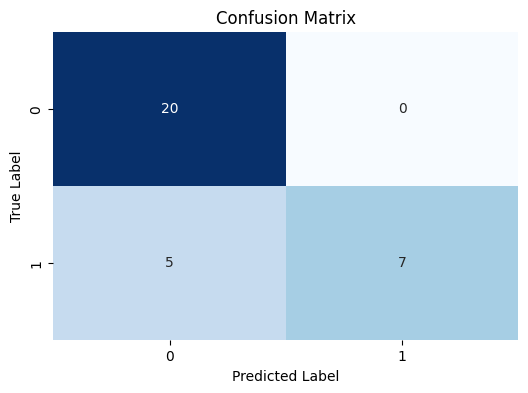

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(model, validation_data):
    # Get a batch of validation data
    val_data, val_labels = validation_data.__next__()  # Use __next__ to get a batch

    # Predict on the validation data batch
    val_preds = model.predict(val_data)
    val_preds = np.round(val_preds).astype(int)

    # Calculate the confusion matrix
    cm = confusion_matrix(val_labels, val_preds)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()


# Call the confusion matrix function after training
plot_confusion_matrix(model, validation_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

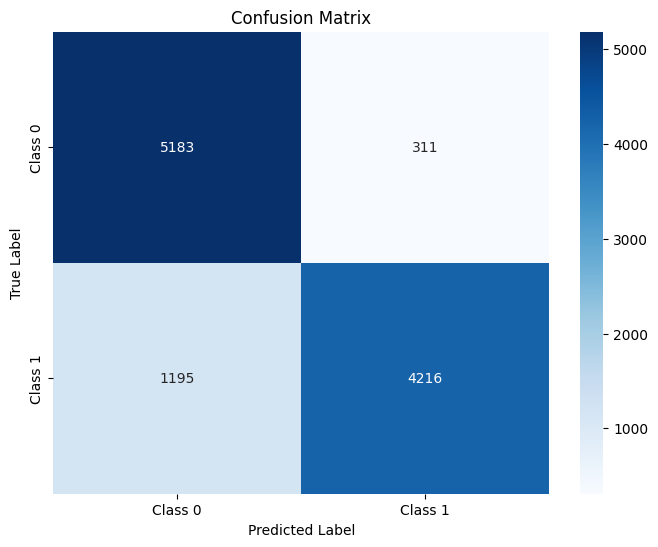

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, validation_data):
    true_labels = []
    predictions = []

    # Iterate over the entire validation set
    for val_data, val_labels in validation_data:
        preds = model.predict(val_data)
        preds = np.round(preds).astype(int)  # Round predictions to binary class (0 or 1)

        true_labels.extend(val_labels)
        predictions.extend(preds)

        # Stop after one full pass (if validation_data is a generator)
        if len(true_labels) >= validation_data.samples:
            break

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function after training
plot_confusion_matrix(model, validation_data)


In [17]:
from sklearn.metrics import classification_report

def generate_classification_report(model, validation_data):
    true_labels = []
    predictions = []

    # Iterate over the entire validation set
    for val_data, val_labels in validation_data:
        preds = model.predict(val_data)
        preds = np.round(preds).astype(int)  # Round predictions to get binary class (0 or 1)

        true_labels.extend(val_labels)
        predictions.extend(preds)

        # Stop after one full pass (if validation_data is a generator)
        if len(true_labels) >= validation_data.samples:
            break

    # Generate classification report
    report = classification_report(true_labels, predictions, target_names=['Class 0', 'Class 1'])

    # Print classification report
    print("Classification Report:\n")
    print(report)

# Call the function after training
generate_classification_report(model, validation_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

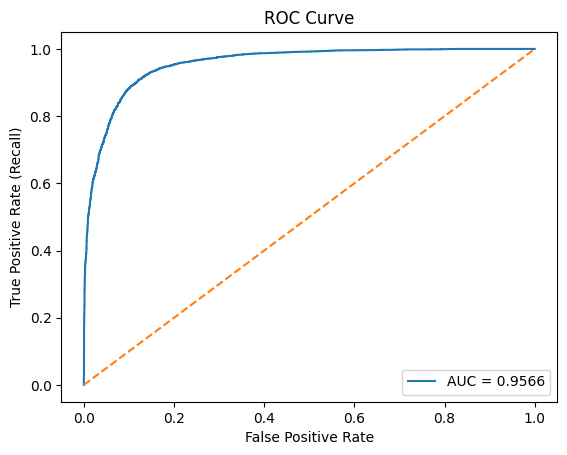

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(model, validation_data):
    true_labels = []
    predictions = []

    for val_data, val_labels in validation_data:
        preds = model.predict(val_data).ravel()  # Get probability scores for positive class

        true_labels.extend(val_labels)
        predictions.extend(preds)

        if len(true_labels) >= validation_data.samples:
            break

    # Calculate AUC-ROC
    auc = roc_auc_score(true_labels, predictions)

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, predictions)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Call the function after training
plot_roc_curve(model, validation_data)


In [19]:
from sklearn.metrics import log_loss

def calculate_log_loss(model, validation_data):
    true_labels = []
    predictions = []

    for val_data, val_labels in validation_data:
        preds = model.predict(val_data).ravel()  # Get probability scores for positive class

        true_labels.extend(val_labels)
        predictions.extend(preds)

        if len(true_labels) >= validation_data.samples:
            break

    # Calculate Log Loss
    loss = log_loss(true_labels, predictions)

    # Print log loss
    print(f"Log Loss: {loss:.4f}")

# Call the function after training
calculate_log_loss(model, validation_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━